In [1]:
# Import File
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def DFfromTXT(fileName):
    txt = open(fileName,'r').read()

    # create list of lists from txt
    lines = txt.splitlines()
    xs = [l.split('\t') for l in lines]

    # join the listed proteins if there is more than one
    for x in xs:
        while (len(x) > len(xs[0])):
            x[-2:] = [', '.join(x[-2:])]

    # create a pandas DataFrame from the acquired data
    df = pd.DataFrame(xs[1:], index = range(len(xs[1:])), columns = xs[0])
    return df

def calcQ(df, scoreColName):
    df[scoreColName] = [float(i) for i in df[scoreColName]]
    # Sort by score columns
    df.sort_values(scoreColName, ascending=False, inplace = True)

    # Replace -1 by 0 and turn every element into a number
    df = df[df.Label != '-']
    df.replace(to_replace = '1', value = 1, inplace = True)
    df.replace(to_replace = '-1', value = 0, inplace = True)

    # calculate FDR
    df['FDR'] = 1 - (df['Label'].cumsum()/[i + 1 for i in range(len(df.index))])

    # calculate q-value
    df['q-val'] = df['FDR'][::-1].cummin()[::-1]
    
    return df

def addRanks(df, idColName, scoreColName):
    # Sort by ID and score
    df.sort_values(scoreColName, inplace = True, ascending = False)
    df.sort_values(idColName, inplace = True, kind = 'mergesort')

    # for better performance iterate over lists
    ids = list(df[idColName])
    ranks = []
    lastId = ''
    currRank = 1

    for currId in ids:
        if (currId == lastId):
            currRank += 1
        else:
            currRank = 1
            lastId = currId
        ranks += [currRank]

    df['Rank'] = ranks
    return df

def readAndProcess(fileName, idColName,  scoreColName):
    d = DFfromTXT(fileName)
    print(len(d.index))
    d1 = calcQ(d, scoreColName)
    print(len(d.index))
    df = addRanks(d1, idColName, scoreColName)
    print(len(d.index))
    df.sort_values(scoreColName, inplace = True, ascending = False)
    return df    

def pseudoROC(df, xMax):
    qVals = [df.loc[i, 'q-val'] for i in df.index if (df.loc[i,'q-val'] <= xMax and df.loc[i, 'Rank'] == 1)]
    plt.xlim(0,xMax)
    plt.ylim(0,len(qVals))
    plt.plot(qVals, range(len(qVals)))

In [2]:
idCol = 'SpecId'
scoreCol = 'NuXL:score'

dFast = readAndProcess('../Data/1-AChernev_080219_dir_HeLa_cyt_UCGA_fast.tsv', idCol, scoreCol)
dSlow = readAndProcess('../Data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol)

dFast['NuXL:isXL'] = [int(x) for x in dFast['NuXL:isXL']]
dSlow['NuXL:isXL'] = [int(x) for x in dSlow['NuXL:isXL']]

dFast.head()

55829
55829
55829
93219
93219
93219


,SpecId,Label,ScanNr,ExpMass,CalcMass,mass,peplen,charge2,charge3,charge4,...,precursor_purity,NuXL:XL_U,NuXL:XL_C,NuXL:XL_G,NuXL:XL_A,Peptide,Proteins,FDR,q-val,Rank
9450,controllerType=0controllerNumber=1scan=8704,1,8704,1075.096069335940001,1075.098715746004473,1075.096069335940001,40,0,1,0,...,1.0,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1
9523,controllerType=0controllerNumber=1scan=8757,1,8757,1075.099487304690001,1075.098715746004473,1075.099487304690001,40,0,1,0,...,1.0,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1
7438,controllerType=0controllerNumber=1scan=7273,1,7273,906.114624023437955,906.114605851646047,906.114624023437955,44,0,0,1,...,0.969195320917585,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGKSSHS.-,sp|P35527|K1C9_HUMAN,0.0,0.0,1
8544,controllerType=0controllerNumber=1scan=7991,1,7991,1336.114624023440228,1336.114549096904966,1336.114624023440228,32,0,1,0,...,1.0,0,0,0,0,K.KKEEEEDEEDEEDEEEEEDEEDEDEEEDDDDE.-,sp|P09429|HMGB1_HUMAN,0.0,0.0,1
8614,controllerType=0controllerNumber=1scan=8046,1,8046,1336.115234375,1336.114549096904966,1336.115234375,32,0,1,0,...,0.992818714425246,0,0,0,0,K.KKEEEEDEEDEEDEEEEEDEEDEDEEEDDDDE.-,sp|P09429|HMGB1_HUMAN,0.0,0.0,1


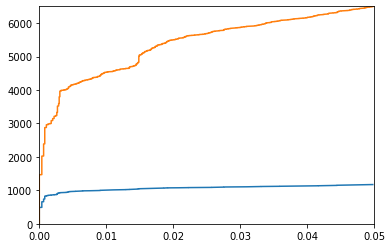

In [7]:
df = dFaNoXL
xMax = 0.05
qVals = [df.loc[i, 'q-val'] for i in df.index if (df.loc[i,'q-val'] <= xMax)]
plt.xlim(0,xMax)
plt.ylim(0,len(qVals))
plt.plot(qVals, range(len(qVals)))
df = dFaXL
qVals = [df.loc[i, 'q-val'] for i in df.index if (df.loc[i,'q-val'] <= xMax)]
plt.xlim(0,xMax)
plt.ylim(0,len(qVals))
plt.plot(qVals, range(len(qVals)))

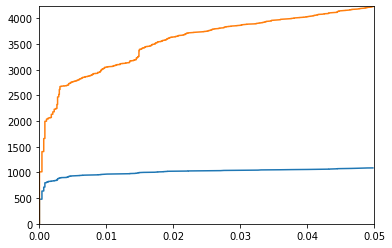

In [3]:
dFaXL = dFast[dFast['NuXL:isXL'] == 1]
dFaNoXL = dFast[dFast['NuXL:isXL'] == 0]
pseudoROC(dFaNoXL, 0.05)
pseudoROC(dFaXL, 0.05)

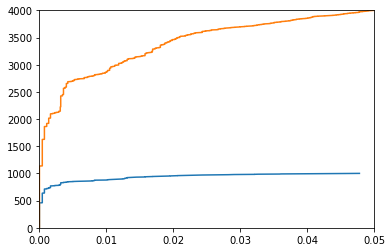

In [4]:
dSlXL = dSlow[dSlow['NuXL:isXL'] == 1]
dSlNoXL = dSlow[dSlow['NuXL:isXL'] == 0]
pseudoROC(dSlNoXL, 0.05)
pseudoROC(dSlXL, 0.05)

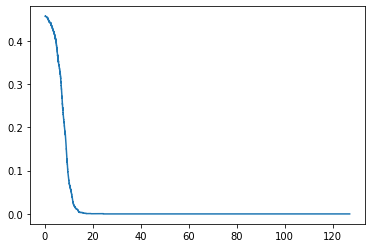

In [5]:
df = dSlow
x = [float(x) for x in df[scoreCol]]
y = [float(x) for x in df['FDR']]
plt.plot(x, y)